In [25]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot
from sklearn import preprocessing

In [26]:
# Loading the MNIST datasets - 60000 images for training and 10000 images for testing
(imageTrainRaw, labelTrainRaw), (imageTestRaw, labelTestRaw) = tf.keras.datasets.mnist.load_data()

# Splitting the training set into 2: 55000 images for training and 5000 images for validation
imageTestRaw = imageTestRaw[:]
labelTestRaw = labelTestRaw[:]
imageValidRaw = imageTrainRaw[55000:]
labelValidRaw = labelTrainRaw[55000:]
imageTrainRaw = imageTrainRaw[:55000]
labelTrainRaw = labelTrainRaw[:55000]

def printArr(idx):
    to_write = ""
    for i in range(28):
        for j in range(28):
            if(len(str(imageTrainRaw[idx][i][j])) == 1):
                to_write += str(imageTrainRaw[idx][i][j]) + "    "
            elif(len(str(imageTrainRaw[idx][i][j])) == 2):
                to_write += str(imageTrainRaw[idx][i][j]) + "   "
            else:
                to_write += str(imageTrainRaw[idx][i][j]) + "  "
        to_write += "\n"
    to_write += f"\nDigit: {labelTrainRaw[idx]}"
    with open("./test/imageArr.txt", "w") as file:
        file.write(to_write)

printArr(idx = 7)

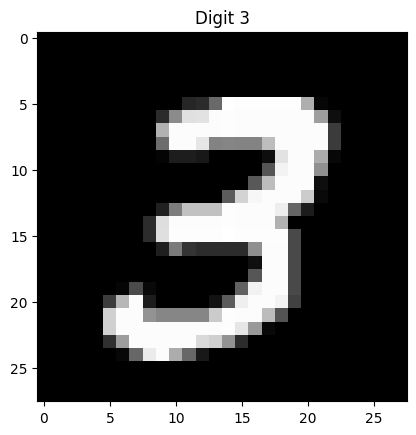

In [27]:
# Plotting an image
def plotImage(idx):
    pyplot.title(f"Digit {labelTrainRaw[idx]}")
    pyplot.imshow(imageTrainRaw[idx], cmap='gray')
    pyplot.savefig("./test/digitGrey.jpg")
    
plotImage(idx = 7)

In [28]:
# Preprocessing data (normalizing image arrays and 1-hot encoding label arrays)
imageTest = np.reshape(imageTestRaw, (10000, 784))
imageTest = preprocessing.normalize(imageTest, norm = "max")
labelTest = tf.keras.utils.to_categorical(labelTestRaw, num_classes=10)

imageValid = np.reshape(imageValidRaw, (5000, 784))
imageValid = preprocessing.normalize(imageValid, norm = "max")
labelValid = tf.keras.utils.to_categorical(labelValidRaw, num_classes=10)

imageTrain = np.reshape(imageTrainRaw, (55000, 784))
imageTrain = preprocessing.normalize(imageTrain, norm="max")
labelTrain = tf.keras.utils.to_categorical(labelTrainRaw, num_classes=10)

In [29]:
# Setting up the neural network layer dimension and hypermeters 
iter = 20000      # Number of iterations
sizeTrain = 55000 # Images in train set
sizeValid = 5000  # Images in train set
batchSize = 50    # Batch size
etaInit = 0.05    # Initial learning rate
etaDecay = 1      # Learning rate decay
dInput = 784      # Input layer (28x28 pixels)
dHidden = 400     # Hidden layer (16x16 pixel)
dOutput = 10      # Output layer (0-9 digits)

In [30]:
# ReLU activation for hidden layer
def relu(x):
    return np.maximum(0, x)

# Softmax activation for output layer
def softmax(x):
    c = np.max(x, axis = 0)
    x -= c
    e = np.exp(x)
    return e / sum(e)

# Calculating loss value using cross entropy
def flossSGD(yCal, yLabel):
    result = sum(- np.log(yCal)[idx] * yLabel[idx] for idx in range(10))
    return result

def floss(yCal, yLabel):
    result = -np.sum(np.log(yCal) * yLabel) / batchSize
    return result

In [35]:
# Initializing weights, biases and eta
w1 = 0.01 * np.random.rand(dInput, dHidden)
b1 = 0.01 * np.random.rand(dHidden, batchSize)
w2 = 0.01 * np.random.rand(dHidden, dOutput)
b2 = 0.01 * np.random.rand(dOutput, batchSize)
eta = etaInit

lossPrev = 100000
to_write = ""
for n in range(iter + 1):
    idxList = np.random.randint(sizeTrain, size=batchSize)
    # Feedforward
    x = imageTrain[idxList].T
    z1 = np.dot(w1.T, x) + b1
    a1 = relu(z1)
    z2 = np.dot(w2.T, a1) + b2
    a2 = softmax(z2)
    yCal = a2 
    yLabel = labelTrain[idxList].T
    loss = floss(yCal, yLabel) 
    if(loss < lossPrev):
        lossPrev = loss
        w1Res = w1
        b1Res = b1
        w2Res = w2
        b2Res = b2
        print(f"[Iter {n}] Loss: {loss}")
        to_write += f"[Iter {n}] Loss: {loss}\n"
        
    # Backpropagation
    e2 = (yCal - yLabel) / batchSize # gradient of softmax using cross entropy
    dw2 = np.dot(a1, e2.T)
    db2 = sum(e2)
    e1 = np.dot(w2, e2)
    e1[z1 <= 0] = 0 # gradient of ReLU
    dw1 = np.dot(x, e1.T)
    db1 = sum(e1)

    # Updating weights and biases
    w1 += -eta * dw1
    b1 += -eta * db1
    w2 += -eta * dw2
    b2 += -eta * db2

with open("./test/lossMin.txt", "w") as file:
    file.write(to_write)

In [34]:
count = 0
batch = 0
while batch < 10000:
    idxList = np.arange(batch, batch + batchSize, 1)
    x = imageTest[idxList].T
    z1 = np.dot(w1Res.T, x) + b1Res
    a1 = relu(z1)
    z2 = np.dot(w2Res.T, a1) + b2Res
    a2 = softmax(z2)
    yLabel = labelTest[idxList]
    prediction = np.argmax(a2.T, axis=1)
    answer = np.argmax(yLabel, axis = 1)
    for n in range(50):
        if(prediction[n] == answer[n]):
            count += 1
    batch += batchSize

print(count / 10000)

0.9757
